In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
from matplotlib.pylab import rcParams

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbzz.root")
backgroundFile=TFile.Open("samples/sig_nonres_bbww.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  75809
background events number before cut is:  84531


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(75809, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

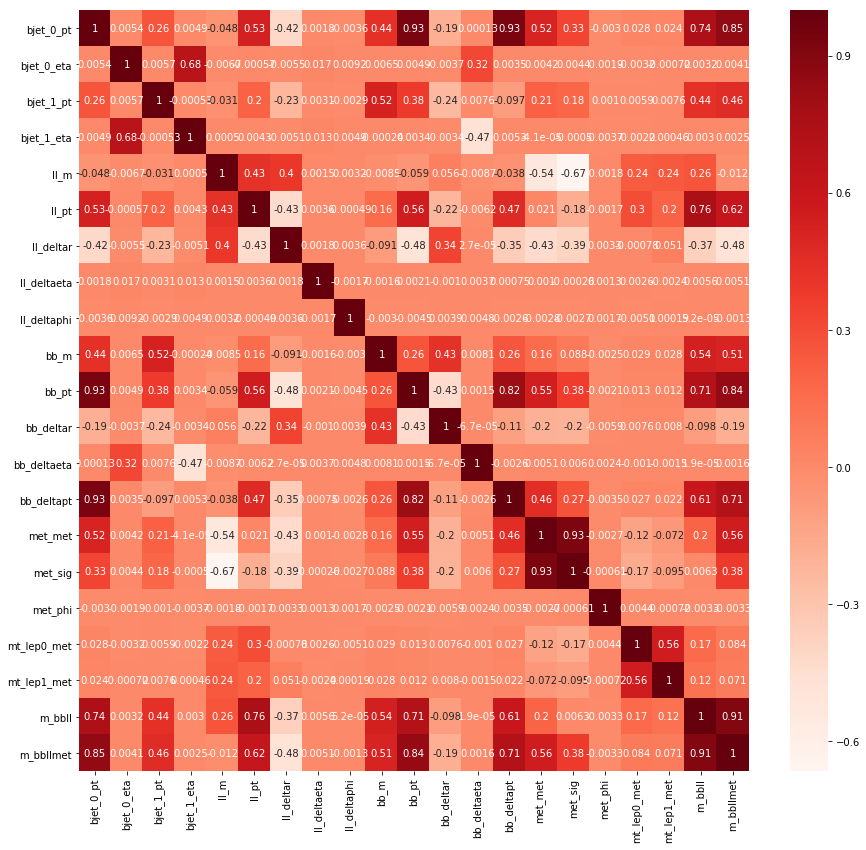

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

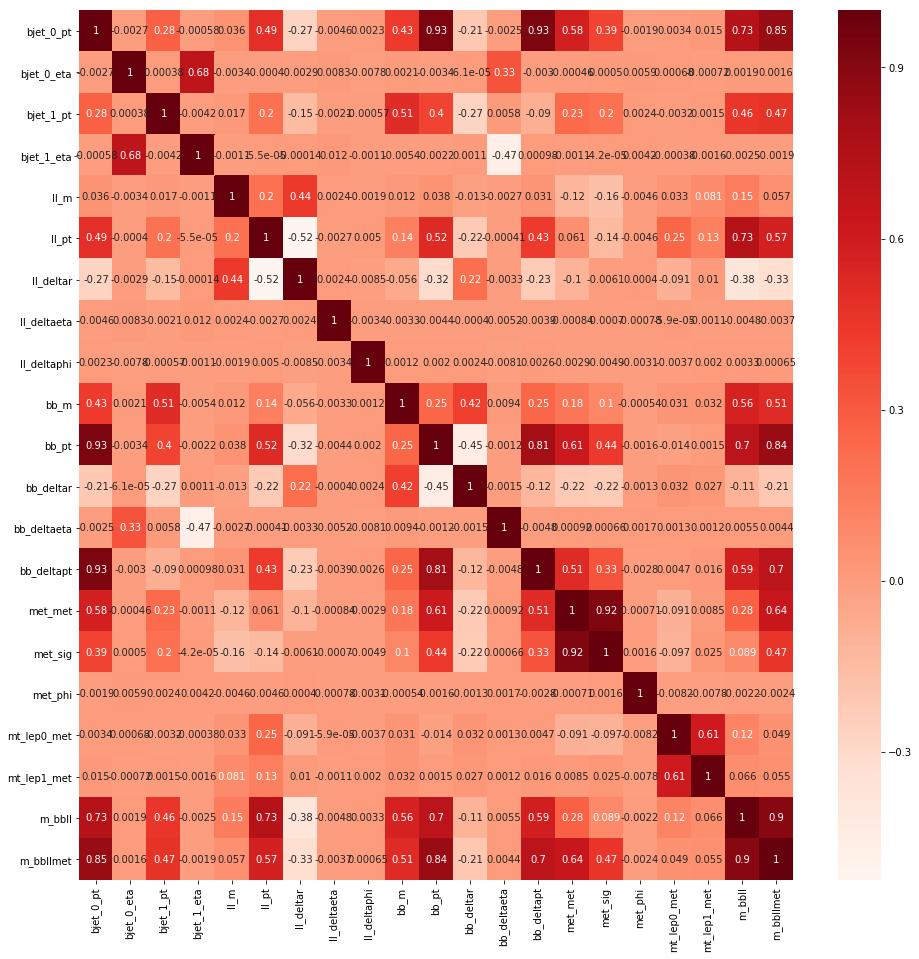

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 7.44818327e-07  1.06398070e+05 -8.51465642e-01 ...  1.67548516e+04
   4.26808188e+05  4.88755188e+05]
 [ 1.59458984e-07  2.06580719e+05 -1.27479148e+00 ...  5.15779141e+04
   7.98903688e+05  8.56081875e+05]
 [ 8.09472716e-07  1.32475984e+05  3.39121938e-01 ...  1.92662500e+04
   2.89801688e+05  4.88526250e+05]
 ...
 [ 1.65113239e-07  1.02363820e+05  8.04546416e-01 ...  4.17481328e+04
   8.63429250e+05  8.78042938e+05]
 [ 1.93601197e-07  3.54055469e+05 -2.08675280e-01 ...  2.02780938e+04
   7.03278562e+05  8.30059688e+05]
 [-9.16766753e-08  3.64696844e+05  4.29171950e-01 ...  2.43024629e+04
   5.73283750e+05  9.84956125e+05]]


In [10]:
print(signalArray[:,1])

[106398.0703125 206580.71875   132475.984375  ... 102363.8203125
 354055.46875   364696.84375  ]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

75809
84531


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  75809
background event number after cut is: 84531


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  68228
testing signal events number is:  7581
training background events number is:  76077
testing background events number is:  8454


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[ 0.00000000e+00  4.16202734e-05  4.79415391e+04 ...  4.88386211e+04
   2.31250766e+05  3.32635469e+05]
 [ 0.00000000e+00 -7.80315236e-05  1.56969297e+05 ...  3.01040137e+04
   2.94178031e+05  3.40084406e+05]
 [ 0.00000000e+00  1.78520990e-04  7.71202266e+04 ...  4.16384805e+04
   2.88623750e+05  3.31104625e+05]
 ...
 [ 0.00000000e+00  3.55027821e-05  2.96649750e+05 ...  2.59003438e+04
   5.96842312e+05  6.81144688e+05]
 [ 0.00000000e+00  2.35798722e-05  2.67666750e+05 ...  1.25640796e+03
   5.48284625e+05  7.73538562e+05]
 [ 0.00000000e+00  6.86499316e-06  1.76849109e+05 ...  5.30523867e+04
   4.77484812e+05  8.07346125e+05]]
0.01503732995226147


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(144305, 21) dtype=float32>

Signal and background training sets should have same yield in training

(144305,)
(144305,)


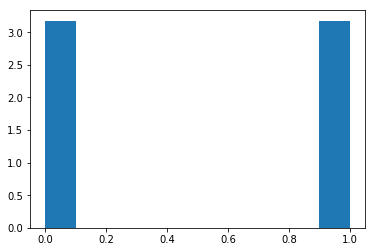

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["binary_accuracy"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalNN=model.predict(signalSample[:,1:])
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample)

In [ ]:
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_4lNN.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalArray[:,1:])
backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
cuda.select_device(0)
cuda.close()

In [18]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
param = {'max_depth': 5, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_exact'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [19]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.787174	train-auc:0.783815
[1]	eval-auc:0.811881	train-auc:0.813005
[2]	eval-auc:0.834378	train-auc:0.831957
[3]	eval-auc:0.825505	train-auc:0.823327
[4]	eval-auc:0.831192	train-auc:0.829703
[5]	eval-auc:0.830999	train-auc:0.827441
[6]	eval-auc:0.832541	train-auc:0.829134
[7]	eval-auc:0.852036	train-auc:0.851824
[8]	eval-auc:0.853536	train-auc:0.853188
[9]	eval-auc:0.854278	train-auc:0.854744
[10]	eval-auc:0.855043	train-auc:0.855405
[11]	eval-auc:0.857143	train-auc:0.857805
[12]	eval-auc:0.857717	train-auc:0.858538
[13]	eval-auc:0.859906	train-auc:0.860087
[14]	eval-auc:0.860244	train-auc:0.860423
[15]	eval-auc:0.860176	train-auc:0.860289
[16]	eval-auc:0.861053	train-auc:0.860996
[17]	eval-auc:0.862153	train-auc:0.861924
[18]	eval-auc:0.862958	train-auc:0.862627
[19]	eval-auc:0.863775	train-auc:0.86299
[20]	eval-auc:0.864255	train-auc:0.86338
[21]	eval-auc:0.866966	train-auc:0.865769
[22]	eval-auc:0.867555	train-auc:0.86606
[23]	eval-auc:0.86788	train-auc:0.866476
[24]	e

[195]	eval-auc:0.87659	train-auc:0.876876
[196]	eval-auc:0.876591	train-auc:0.876876
[197]	eval-auc:0.876599	train-auc:0.876884
[198]	eval-auc:0.876599	train-auc:0.876884
[199]	eval-auc:0.87659	train-auc:0.876886
[200]	eval-auc:0.876591	train-auc:0.876886
[201]	eval-auc:0.876579	train-auc:0.87689
[202]	eval-auc:0.87658	train-auc:0.87689
[203]	eval-auc:0.876578	train-auc:0.876892
[204]	eval-auc:0.87658	train-auc:0.876892
[205]	eval-auc:0.876576	train-auc:0.87689
[206]	eval-auc:0.876576	train-auc:0.876894
[207]	eval-auc:0.876557	train-auc:0.876906
[208]	eval-auc:0.876559	train-auc:0.876906
[209]	eval-auc:0.876575	train-auc:0.876924
[210]	eval-auc:0.876576	train-auc:0.876924
[211]	eval-auc:0.87657	train-auc:0.876924
[212]	eval-auc:0.87657	train-auc:0.876924
[213]	eval-auc:0.876569	train-auc:0.876928
[214]	eval-auc:0.876569	train-auc:0.876928
[215]	eval-auc:0.876578	train-auc:0.876945
[216]	eval-auc:0.876578	train-auc:0.876945
[217]	eval-auc:0.876558	train-auc:0.876948
[218]	eval-auc:0.876

[387]	eval-auc:0.876468	train-auc:0.877253
[388]	eval-auc:0.876467	train-auc:0.877257
[389]	eval-auc:0.876466	train-auc:0.877258
[390]	eval-auc:0.876466	train-auc:0.877258
[391]	eval-auc:0.876462	train-auc:0.877258
[392]	eval-auc:0.876461	train-auc:0.877261
[393]	eval-auc:0.876459	train-auc:0.877279
[394]	eval-auc:0.876459	train-auc:0.877279
[395]	eval-auc:0.87646	train-auc:0.87728
[396]	eval-auc:0.87646	train-auc:0.877279
[397]	eval-auc:0.876445	train-auc:0.877274
[398]	eval-auc:0.876444	train-auc:0.877274
[399]	eval-auc:0.876443	train-auc:0.877283
[400]	eval-auc:0.876442	train-auc:0.877282
[401]	eval-auc:0.876449	train-auc:0.877288
[402]	eval-auc:0.876449	train-auc:0.877288
[403]	eval-auc:0.876448	train-auc:0.877289
[404]	eval-auc:0.876448	train-auc:0.877289
[405]	eval-auc:0.876446	train-auc:0.87729
[406]	eval-auc:0.876446	train-auc:0.87729
[407]	eval-auc:0.876447	train-auc:0.877291
[408]	eval-auc:0.876447	train-auc:0.877291
[409]	eval-auc:0.876446	train-auc:0.877292
[410]	eval-auc:0

[579]	eval-auc:0.876433	train-auc:0.877691
[580]	eval-auc:0.876433	train-auc:0.877691
[581]	eval-auc:0.876433	train-auc:0.877692
[582]	eval-auc:0.876433	train-auc:0.877692
[583]	eval-auc:0.876432	train-auc:0.877693
[584]	eval-auc:0.876432	train-auc:0.877693
[585]	eval-auc:0.876431	train-auc:0.877694
[586]	eval-auc:0.87646	train-auc:0.877712
[587]	eval-auc:0.876461	train-auc:0.877715
[588]	eval-auc:0.876461	train-auc:0.877715
[589]	eval-auc:0.876451	train-auc:0.87772
[590]	eval-auc:0.876451	train-auc:0.87772
[591]	eval-auc:0.87645	train-auc:0.87772
[592]	eval-auc:0.87645	train-auc:0.87772
[593]	eval-auc:0.87645	train-auc:0.877723
[594]	eval-auc:0.876452	train-auc:0.87774
[595]	eval-auc:0.876451	train-auc:0.877741
[596]	eval-auc:0.876451	train-auc:0.877741
[597]	eval-auc:0.876443	train-auc:0.877746
[598]	eval-auc:0.876443	train-auc:0.877746
[599]	eval-auc:0.876442	train-auc:0.877748
[600]	eval-auc:0.876448	train-auc:0.877765
[601]	eval-auc:0.876447	train-auc:0.877764
[602]	eval-auc:0.876

[771]	eval-auc:0.876437	train-auc:0.877901
[772]	eval-auc:0.876437	train-auc:0.877901
[773]	eval-auc:0.876437	train-auc:0.877901
[774]	eval-auc:0.876437	train-auc:0.877901
[775]	eval-auc:0.876406	train-auc:0.877901
[776]	eval-auc:0.876406	train-auc:0.877901
[777]	eval-auc:0.876394	train-auc:0.877903
[778]	eval-auc:0.876394	train-auc:0.877903
[779]	eval-auc:0.876394	train-auc:0.877904
[780]	eval-auc:0.876394	train-auc:0.877903
[781]	eval-auc:0.876394	train-auc:0.877904
[782]	eval-auc:0.876394	train-auc:0.877904
[783]	eval-auc:0.876394	train-auc:0.877904
[784]	eval-auc:0.876394	train-auc:0.877904
[785]	eval-auc:0.876394	train-auc:0.877905
[786]	eval-auc:0.876394	train-auc:0.877905
[787]	eval-auc:0.876393	train-auc:0.877906
[788]	eval-auc:0.876393	train-auc:0.877905
[789]	eval-auc:0.876393	train-auc:0.877906
[790]	eval-auc:0.876393	train-auc:0.877906
[791]	eval-auc:0.876393	train-auc:0.877907
[792]	eval-auc:0.876392	train-auc:0.877907
[793]	eval-auc:0.876392	train-auc:0.877908
[794]	eval-

[963]	eval-auc:0.876348	train-auc:0.878022
[964]	eval-auc:0.876346	train-auc:0.878018
[965]	eval-auc:0.876346	train-auc:0.878023
[966]	eval-auc:0.876345	train-auc:0.878023
[967]	eval-auc:0.876345	train-auc:0.878024
[968]	eval-auc:0.876345	train-auc:0.878024
[969]	eval-auc:0.876345	train-auc:0.878026
[970]	eval-auc:0.876343	train-auc:0.878025
[971]	eval-auc:0.876344	train-auc:0.878027
[972]	eval-auc:0.876343	train-auc:0.878026
[973]	eval-auc:0.876344	train-auc:0.878027
[974]	eval-auc:0.876343	train-auc:0.878027
[975]	eval-auc:0.876344	train-auc:0.878027
[976]	eval-auc:0.876343	train-auc:0.878027
[977]	eval-auc:0.876343	train-auc:0.878028
[978]	eval-auc:0.876343	train-auc:0.878028
[979]	eval-auc:0.876343	train-auc:0.878029
[980]	eval-auc:0.876344	train-auc:0.878028
[981]	eval-auc:0.876344	train-auc:0.878029
[982]	eval-auc:0.876343	train-auc:0.878028
[983]	eval-auc:0.876344	train-auc:0.878029
[984]	eval-auc:0.876344	train-auc:0.878029
[985]	eval-auc:0.876343	train-auc:0.87803
[986]	eval-a

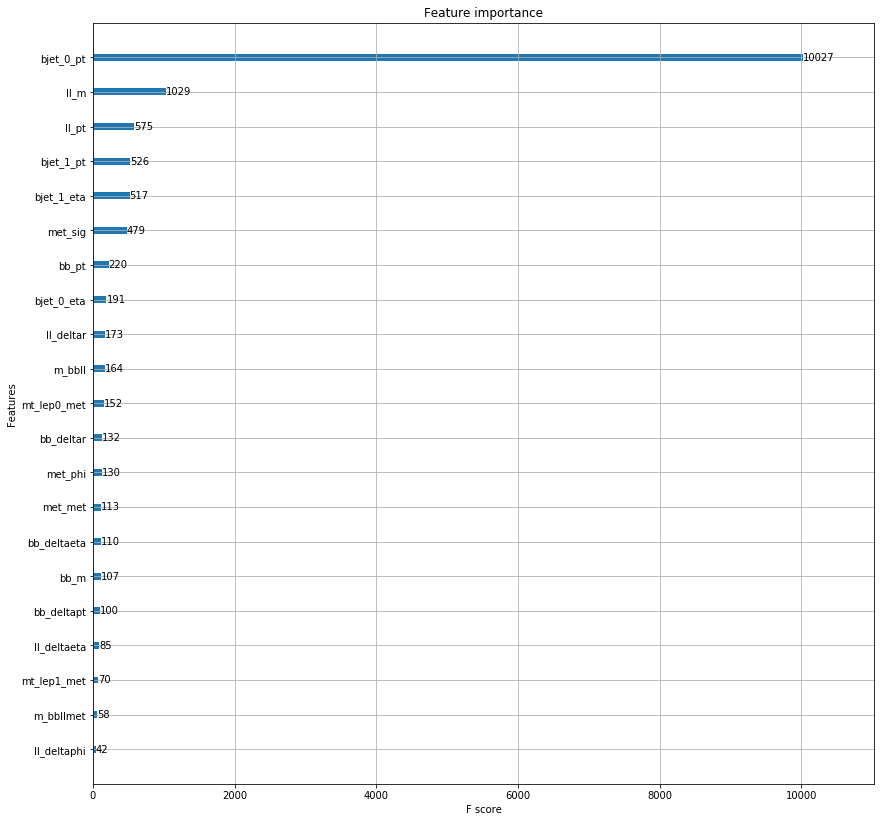

In [20]:
fig, ax = plt.subplots(figsize=(14, 14))
xgb.plot_importance(GBDT,ax=ax)

(array([ 1063.,  7454.,  8476., 12769.,  8802., 10851., 10219.,  5296.,
         5852.,  7997.,  1997.,  1924.,   715.,   354.,   217.,   252.,
          132.,    55.,    29.,    77.]),
 array([0.0054925 , 0.05492557, 0.10435864, 0.15379171, 0.20322478,
        0.25265786, 0.3020909 , 0.351524  , 0.40095708, 0.45039013,
        0.4998232 , 0.54925627, 0.5986894 , 0.64812243, 0.6975555 ,
        0.74698853, 0.79642165, 0.8458547 , 0.89528775, 0.94472086,
        0.9941539 ], dtype=float32),
 <a list of 20 Patch objects>)

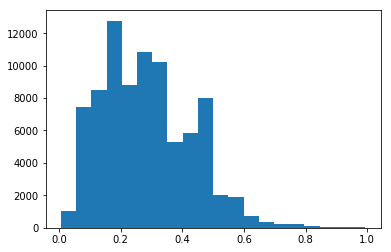

In [21]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

(array([  147.,   513.,   824.,  2761.,  2719.,  4416.,  5108.,  3501.,
         4397.,  6752.,  2238.,  2679.,  1281.,  1391.,  1499.,  2153.,
         2651.,  2759.,  3243., 24777.]),
 array([0.01358078, 0.06260943, 0.11163809, 0.16066675, 0.2096954 ,
        0.25872406, 0.30775273, 0.35678136, 0.40581003, 0.4548387 ,
        0.5038673 , 0.552896  , 0.60192466, 0.6509533 , 0.699982  ,
        0.7490106 , 0.7980393 , 0.84706795, 0.8960966 , 0.9451253 ,
        0.9941539 ], dtype=float32),
 <a list of 20 Patch objects>)

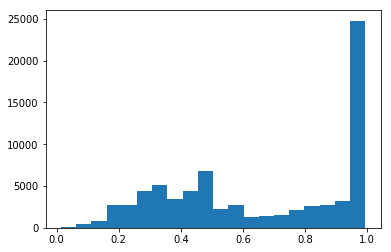

In [22]:
plt.hist(SignalScore,bins=20)

(array([ 1041.,  7078.,  8381., 13889., 10176., 13879., 13906.,  7640.,
         9406., 13439.,  3871.,  4019.,  1926.,  1569.,  1549.,  2155.,
         2535.,  2517.,  2931., 22398.]),
 array([0.0054925 , 0.05492557, 0.10435864, 0.15379171, 0.20322478,
        0.25265786, 0.3020909 , 0.351524  , 0.40095708, 0.45039013,
        0.4998232 , 0.54925627, 0.5986894 , 0.64812243, 0.6975555 ,
        0.74698853, 0.79642165, 0.8458547 , 0.89528775, 0.94472086,
        0.9941539 ], dtype=float32),
 <a list of 20 Patch objects>)

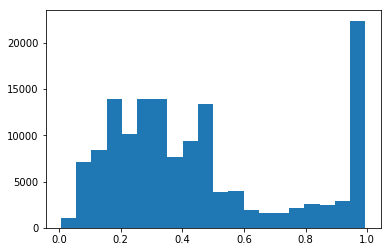

In [23]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [24]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

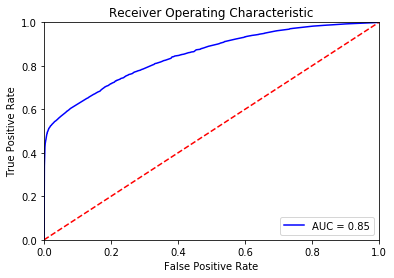

<Figure size 432x288 with 0 Axes>

In [25]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("WW-ZZ-training-roc.png")

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("WW-ZZ-testing-roc.pdf")

In [ ]:
pickle.dump(GBDT, open("GBDT_HHzzww.pickle.dat", "wb"))

In [26]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

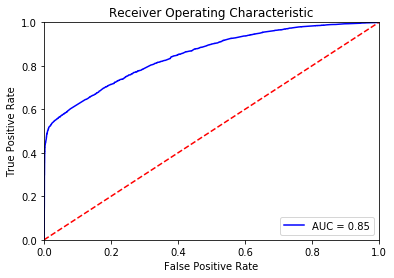

<Figure size 432x288 with 0 Axes>

In [27]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("WW-ZZ-testing-roc.png")

In [ ]:
rcParams['figure.figsize'] = 80,50
plot_tree(GBDT, num_trees=4)